In [ ]:
#attraction of α to OTOs with low value

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid

In [15]:
def calc_beta(m_list, delta, K):
    m = np.sum(m_list)
    m_ratio = np.sqrt(np.array(m_list)) / m  
    return m_ratio.sum() * np.sqrt(2 * np.log(K / delta))

def conf_bound(n, K, delta):
    return np.sqrt(np.log(K / delta) / (2 * np.maximum(n, 1e-8)))

In [16]:
class OTOBandit:
    def __init__(self, means, m_list, T=2, alpha=0.2):
        self.K = len(means)
        self.means = np.array(means)
        self.T = T
        self.alpha = alpha
        self.delta = 1 / (T ** 2)
        # Offline statistics
        self.n = np.zeros(self.K)
        self.s = np.zeros(self.K)
        self.mu_hat_0 = np.zeros(self.K)
        for i in range(self.K):
            mi = m_list[i]
            if mi > 0:
                offline_samples = np.random.binomial(1, self.means[i], mi)
                self.mu_hat_0[i] = np.mean(offline_samples)
                self.n[i] = mi
                self.s[i] = offline_samples.sum()
        self.TU = np.zeros(self.K)
        self.TL = np.zeros(self.K)
        self.beta = calc_beta(m_list, self.delta, self.K)
        lcb0 = self.mu_hat_0 - conf_bound(np.maximum(self.n, 1), self.K, self.delta)
        lcb0[self.n == 0] = -np.inf
        L0 = np.argmax(lcb0)
        self.gamma = lcb0[L0] - self.alpha * self.beta

    def step(self, t, flag=True):
        if flag == False:
            self.delta = 0.01 / ((t+1) ** 2)
        mu_hat = np.zeros(self.K)
        for i in range(self.K):
            if self.n[i] > 0:
                mu_hat[i] = self.s[i] / self.n[i]
            else:
                mu_hat[i] = 0.0
        cb = conf_bound(self.n, self.K, self.delta)
        ucb = mu_hat + cb
        lcb = mu_hat - cb
        ucb[self.n == 0] = 1
        lcb[self.n == 0] = -1
        mu_max_ucb = np.max(ucb)
        mu_max_lcb = np.max(lcb)
        budget = np.sum(self.TU * (lcb - self.gamma)) + (mu_max_ucb - self.gamma) + ((self.TL.sum() + self.T - (t+1)) * self.alpha * self.beta)
        if budget > 0:
            i_star = np.argmax(ucb)
            self.TU[i_star] += 1
        else:
            i_star = np.argmax(lcb)
            self.TL[i_star] += 1
        reward = np.random.binomial(1, self.means[i_star])
        self.n[i_star] += 1
        self.s[i_star] += reward
        return i_star, reward

In [17]:
def UCB_step(n, s, t, K):
    delta = 1/(t**2)
    mu = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
    cb = np.sqrt(np.log(K/delta) / (2 * np.maximum(n, 1e-8)))
    ucb = mu + cb
    ucb[n==0] = 1
    return np.argmax(ucb)

def LCB_step(n, s, t, K):
    delta = 1/(t**2)
    mu = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
    cb = np.sqrt(np.log(K/delta) / (2 * np.maximum(n, 1e-8)))
    lcb = mu - cb
    lcb[n==0] = -1
    return np.argmax(lcb)

In [18]:
class SoftSwitchOTO(OTOBandit):
    def __init__(self, means, m_list, T=2, alpha=0.2, temperature=2.0):
        super().__init__(means, m_list, T, alpha)
        self.temperature = temperature

    def step(self, t, flag = True):
        if flag == False:
            self.delta = 0.01 / ((t+1) ** 2)
        mu_hat = np.zeros(self.K)
        for i in range(self.K):
            if self.n[i] > 0:
                mu_hat[i] = self.s[i] / self.n[i]
            else:
                mu_hat[i] = 0.0
        cb = conf_bound(self.n, self.K, self.delta)
        ucb = mu_hat + cb
        lcb = mu_hat - cb
        ucb[self.n == 0] = 1
        lcb[self.n == 0] = -1
        mu_max_ucb = np.max(ucb)
        mu_max_lcb = np.max(lcb)
        budget = (
            np.sum(self.TU * (lcb - self.gamma))
            + (mu_max_ucb - self.gamma)
            + ((self.TL.sum() + self.T - (t + 1)) * self.alpha * self.beta)
        )
        # 用sigmoid将budget转为概率
        p_ucb = expit(budget / self.temperature)  # sigmoid
        if np.random.rand() < p_ucb:
            i_star = np.argmax(ucb)
            self.TU[i_star] += 1
        else:
            i_star = np.argmax(lcb)
            self.TL[i_star] += 1
        reward = np.random.binomial(1, self.means[i_star])
        self.n[i_star] += 1
        self.s[i_star] += reward
        return i_star, reward

In [19]:
def run_bandit(instance_means, m_list, T, algorithm, alpha=0.2):
    '''
    instance_means: array, arm true means
    m_list: list, offline samples per arm
    T: horizon
    algorithm: 'UCB', 'LCB', 'OTO' or 'SoftOTO'
    '''
    K = len(instance_means)
    delta = 1 / (T ** 2)
    # Offline statistics
    mu_hat_0, n_init = np.zeros(K), np.zeros(K)
    s = np.zeros(K)
    for i in range(K):
        mi = m_list[i]
        if mi > 0:
            offline_samples = np.random.binomial(1, instance_means[i], mi)
            mu_hat_0[i] = np.mean(offline_samples)
            n_init[i] = mi
            s[i] = offline_samples.sum()
        else:
            mu_hat_0[i] = 0.0
            n_init[i] = 0
    m = np.sum(m_list)
    pi = np.array(m_list) / m if m > 0 else np.ones(K)/K
    mu0 = np.dot(pi, instance_means)

    n = n_init.copy()
    # regret记录
    history_regret = []
    if algorithm == 'OTO':
        oto = OTOBandit(instance_means, m_list, T, alpha)
    elif algorithm == 'SoftOTO':
        oto = SoftSwitchOTO(instance_means, m_list, T, alpha, temperature=1.0)
    for t in range(T):
        if algorithm == 'UCB':
            mu_hat = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
            cb = conf_bound(n, K, delta)
            ucb = mu_hat + cb
            ucb[n == 0] = 1
            i_star = np.argmax(ucb)
        elif algorithm == 'LCB':
            mu_hat = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
            cb = conf_bound(n, K, delta)
            lcb = mu_hat - cb
            lcb[n == 0] = -1
            i_star = np.argmax(lcb)
        elif algorithm == 'OTO':
            i_star, reward = oto.step(t)
        elif algorithm == 'SoftOTO':
            i_star, reward = oto.step(t)
        if algorithm in ['UCB', 'LCB']:
            reward = np.random.binomial(1, instance_means[i_star])
            n[i_star] += 1
            s[i_star] += reward
        regret = np.max(instance_means) - instance_means[i_star]
        history_regret.append(regret)
    return np.cumsum(history_regret)

In [20]:
def run_bandit_UH(instance_means, m_list, T, algorithm, alpha=0.2,):
    '''
    instance_means: array, arm true means
    m_list: list, offline samples per arm
    T: horizon
    algorithm: 'UCB', 'LCB', 'OTO' or 'SoftOTO'
    '''
    K = len(instance_means)
    delta = 1 / (T ** 2)
    # Offline statistics
    mu_hat_0, n_init = np.zeros(K), np.zeros(K)
    s = np.zeros(K)
    for i in range(K):
        mi = m_list[i]
        if mi > 0:
            offline_samples = np.random.binomial(1, instance_means[i], mi)
            mu_hat_0[i] = np.mean(offline_samples)
            n_init[i] = mi
            s[i] = offline_samples.sum()
        else:
            mu_hat_0[i] = 0.0
            n_init[i] = 0
    m = np.sum(m_list)
    pi = np.array(m_list) / m if m > 0 else np.ones(K)/K
    mu0 = np.dot(pi, instance_means)

    n = n_init.copy()
    # regret记录
    history_regret = []
    if algorithm == 'OTO':
        oto = OTOBandit(instance_means, m_list, 2, alpha)
    elif algorithm == 'SoftOTO':
        oto = SoftSwitchOTO(instance_means, m_list, 2, alpha, temperature=1.0)
    for t in range(T):
        if algorithm == 'UCB':
            mu_hat = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
            cb = conf_bound(n, K, delta)
            ucb = mu_hat + cb
            ucb[n == 0] = 1
            i_star = np.argmax(ucb)
        elif algorithm == 'LCB':
            mu_hat = np.divide(s, n, out=np.zeros_like(n, dtype=float), where=n>0)
            cb = conf_bound(n, K, delta)
            lcb = mu_hat - cb
            lcb[n == 0] = -1
            i_star = np.argmax(lcb)
        elif algorithm == 'OTO':
            if (t+1)>oto.T:
                oto.T=2*oto.T
            i_star, reward = oto.step(t, False)
        elif algorithm == 'SoftOTO':
            if (t+1)>oto.T:
                oto.T=2*oto.T
            i_star, reward = oto.step(t, False)
        if algorithm in ['UCB', 'LCB']:
            reward = np.random.binomial(1, instance_means[i_star])
            n[i_star] += 1
            s[i_star] += reward
        regret = np.max(instance_means) - instance_means[i_star]
        history_regret.append(regret)
    return np.cumsum(history_regret)

In [21]:
def plot_CertainH():
    np.random.seed(42)
    K, m = 20, 2000
    m_list = [200] * 10 + [0] * 10
    # instance 1
    means1 = np.array([0.5]*10 + [0.25]*10)
    # instance 2
    means2 = np.array([0.5]*10 + [0.25]*9 + [0.75])
    for instance_idx, (means, label) in enumerate([(means1, 'Instance 1'), (means2, 'Instance 2')]):
        for horizon, color in zip([200, 2000], ['tab:blue', 'tab:orange']):
            regrets = {}
            for alg in ['LCB', 'UCB', 'OTO', 'SoftOTO']:
                vals = []
                for rep in range(200):
                    vals.append(run_bandit(means, m_list, horizon, alg, alpha=0.2))
                regrets[alg] = np.mean(vals, axis=0)
                std = np.std(vals, axis=0)
                plt.plot(regrets[alg], label=alg)
                plt.fill_between(np.arange(horizon), regrets[alg]-2*std, regrets[alg]+2*std, alpha=0.1)
            plt.title(f"{label}, T={horizon}")
            plt.xlabel('iteration')
            plt.ylabel('Regret')
            plt.xlim(0, horizon)
            plt.legend()
            plt.tight_layout()
            plt.show()

In [22]:
def plot_UnknownH():
    np.random.seed(42)
    K, m = 20, 2000
    m_list = [200] * 10 + [0] * 10
    # instance 1
    means1 = np.array([0.5]*10 + [0.25]*10)
    # instance 2
    means2 = np.array([0.5]*10 + [0.25]*9 + [0.75])
    for instance_idx, (means, label) in enumerate([(means1, 'Instance 1'), (means2, 'Instance 2')]):
        for horizon, color in zip([200, 2000], ['tab:blue', 'tab:orange']):
            regrets = {}
            for alg in ['LCB', 'UCB', 'OTO', 'SoftOTO']:
                vals = []
                for rep in range(200):
                    vals.append(run_bandit_UH(means, m_list, horizon, alg, alpha=0.2))
                regrets[alg] = np.mean(vals, axis=0)
                std = np.std(vals, axis=0)
                plt.plot(regrets[alg], label=alg)
                plt.fill_between(np.arange(horizon), regrets[alg]-2*std, regrets[alg]+2*std, alpha=0.1)
            plt.title(f"{label}, T={horizon}")
            plt.xlabel('iteration')
            plt.ylabel('Regret')
            plt.xlim(0, horizon)
            plt.legend()
            plt.tight_layout()
            plt.show()

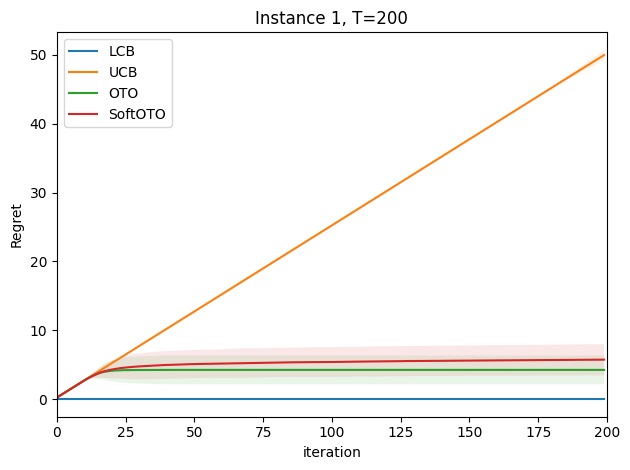

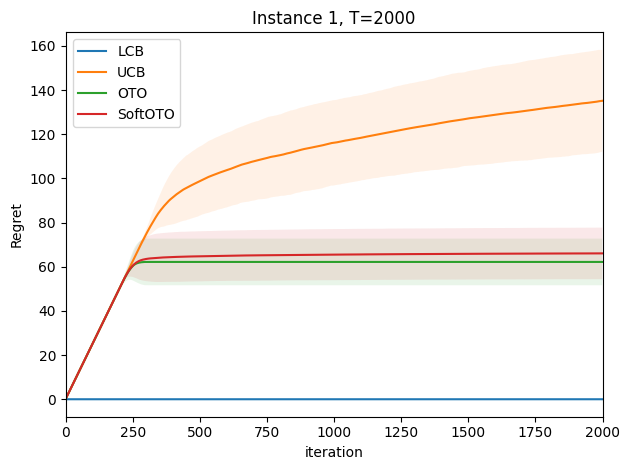

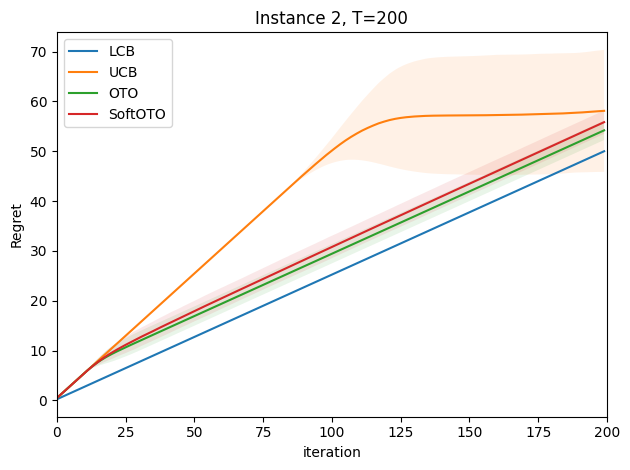

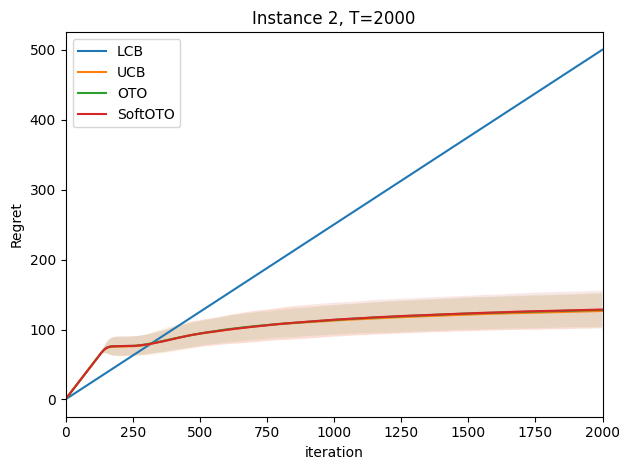

In [24]:
plot_CertainH()

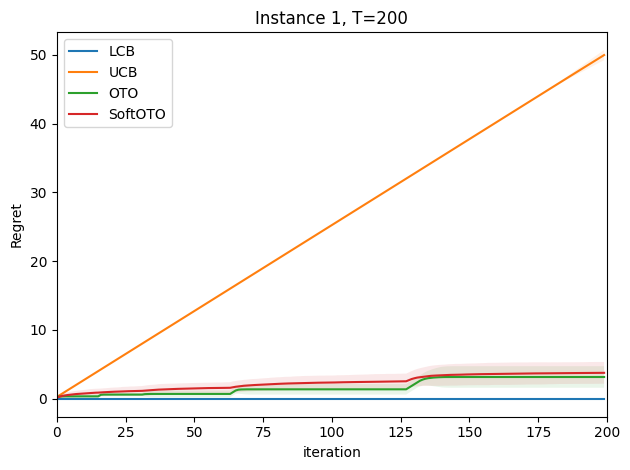

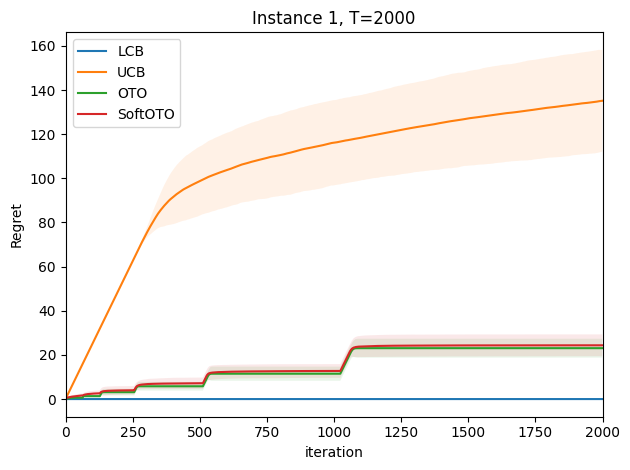

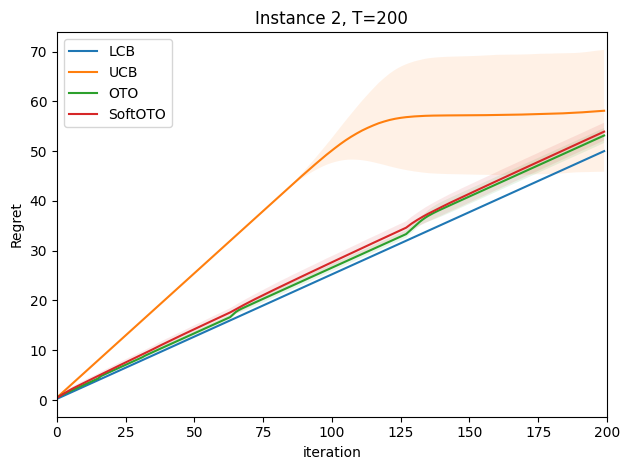

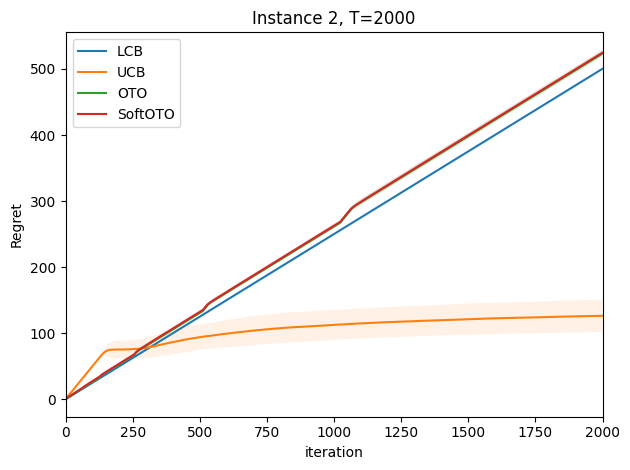

In [23]:
plot_UnknownH()
